# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Ознакомление с данными

In [ ]:
!pip install scikit-learn==1.1.3

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn import tree
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score, 
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    roc_curve,
    auc
)

In [ ]:
df = pd.read_csv('/datasets/Churn.csv')

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
CustomerId,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,9091.0,NaN,NaN,NaN,4.99769,2.894723,0.0,2.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0


Начальные наблюдения:

- столбец RowNumber совпадает с индексом, а также у нас есть уникальный номер клиента, поэтому, скорее всего, можно удалить столбец RowNumber
- столбец Surname, CustomerId не несет для обучения модели никакой информации 
- столбец Tenure имеет пропуски

### Предообработка данных

**Переименуем столбцы**

In [ ]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [ ]:
df = df.rename(columns={
    'RowNumber' : 'row_number',
    'CustomerId' : 'customer_id',
    'Surname' : 'surname',
    'CreditScore' : 'credit_score',
    'Geography' : 'geography',
    'Gender' : 'gender',
    'Age' : 'age',
    'Tenure' : 'tenure', 
    'Balance' : 'balance',
    'NumOfProducts' : 'num_of_products',
    'HasCrCard' : 'has_cr_card',
    'IsActiveMember' : 'is_active_member',
    'EstimatedSalary' : 'estimated_salary',
    'Exited' : 'exited'
})

**1 Удалим столбец RowNumber, так как он совпадает с индексом, а также у нас есть уникальный номер клиента, поэтому можно удалить столбец RowNumber**

In [ ]:
df = df.drop(columns='row_number')
df.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**2 Для обучения модели столбцы customer_id and surname не нужны, поэтому можем их удалить**

In [ ]:
df = df.drop(columns=['customer_id', 'surname'])

df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

**3 Обработаем пропуски в столбце Tenure**

In [ ]:
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [ ]:
df['tenure'].isna().sum()

909

909 пропусков в столбце 'tenure' - порядка 10%

In [ ]:
data_tenure = df.groupby('tenure').agg({'exited' : ['count', 'sum', 'mean']}).reset_index()
data_tenure.columns = ['tenure', 'count', 'sum', 'mean']

data_tenure

,tenure,count,sum,mean
0,0.0,382,90,0.235602
1,1.0,952,213,0.223739
2,2.0,950,185,0.194737
3,3.0,928,198,0.213362
4,4.0,885,184,0.207910
5,5.0,927,187,0.201726
6,6.0,881,177,0.200908
7,7.0,925,160,0.172973
8,8.0,933,174,0.186495
9,9.0,882,194,0.219955


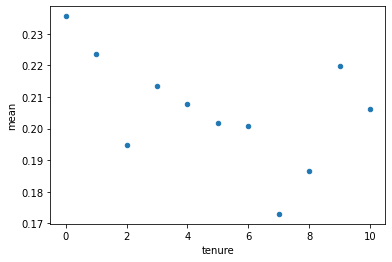

In [ ]:
data_tenure.plot(x='tenure', y='mean', kind='scatter');

In [ ]:
data_tenure['tenure'].corr(data_tenure['mean'])

-0.4707779538461846

Видим, что есть слабая отрицательная корреляция между целевым признаком и значениями в столбце tenure

In [ ]:
df[df['tenure'].isna()].head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


Заполним пропуски значением медианы (медиана = 5)

In [ ]:
df['tenure'] = df['tenure'].fillna(5)

In [ ]:
df['tenure'].isna().sum()

0

Преобразуем столбец tenure в тип int 

In [ ]:
df['tenure'] = df['tenure'].astype('int')

**4 Посмотрим на столбцы is_active_member and 'exited'.** Есть предположение, что не активный клиент - это тот, который ушел и информация в этих столбцах дублирует друг друга

In [ ]:
counter = 0
for i in range(0, len(df['is_active_member'])):
    if (df.loc[i, 'is_active_member'] == 0) & (df.loc[i, 'exited'] == 1):
        counter += 1
counter

1302

In [ ]:
df['is_active_member'].value_counts()

1    5151
0    4849
Name: is_active_member, dtype: int64

In [ ]:
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

Видим, что предположение выше не верно, так как ушло 2037 клиентов, а не активных и которые ушли 1302. Получается есть клиенты, которые еще не ушли, но уже не активны.

In [ ]:
#df.head()

In [ ]:
#df_ohe = pd.get_dummies(df, columns=['geography', 'gender'], drop_first=True)

#df_ohe.columns

In [ ]:
#df_ohe.head()

Теперь надо отмасшабировать количественные признаки, чтобы они для модели были равнозначными

In [ ]:
#numeric = ['credit_score', 'tenure', 'age', 'balance', 'num_of_products', 'estimated_salary']
#pd.options.mode.chained_assignment = None

#scaler = StandardScaler()
#scaler.fit(df_ohe[numeric])
#df_ohe[numeric] = scaler.transform(df_ohe[numeric])

#df_ohe.head()

### Деление на выборки

Нам потребуется 3 выборки: обучающая, валидационная и тестовая для проверки финальной модели. Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 (60%, 20%, 20%)

Для этого сначала разделим данные в отношении 3:2, в потом вторую часть поделим пополам (на валидационную и тестовую), 
при делении на выборки сохраняем исходную стратификацию по целевому признаку

In [ ]:
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['exited'])

In [ ]:
#checking the size of df_train
df_train.shape[0] / df.shape[0]

0.6

In [ ]:
#стратификация в обучающей выборке
df_train.loc[df_train['exited'] == 1, 'exited'].count() / df_train['exited'].shape[0]

0.20366666666666666

In [ ]:
#стратификация в исходном датасете
df.loc[df['exited'] == 1, 'exited'].count() / df['exited'].shape[0]

0.2037

In [ ]:
#divide df_temp at equal datasets (valid and test)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=12345, stratify=df_temp['exited'])

In [ ]:
#checking the size of df_test
df_test.shape[0] / df.shape[0]

0.2

In [ ]:
#стратификация в тестовой выборке
df_test.loc[df_test['exited'] == 1, 'exited'].count() / df_test['exited'].shape[0]

0.2035

In [ ]:
#checking the size of df_valid
df_valid.shape[0] / df.shape[0]

0.2

In [ ]:
#стратификация в валидационной выборке
df_valid.loc[df_valid['exited'] == 1, 'exited'].count() / df_valid['exited'].shape[0]

0.204

Видим, что деление на выборки произведено корректно (60%:20%:20%) и сохранена стратификация (20.4%)

### Деление выборок на признаки и таргеты

In [ ]:
features_train = df_train.drop(columns='exited')
target_train = df_train['exited']

print(features_train.shape)
print(target_train.shape)

(6000, 10)
(6000,)


In [ ]:
features_valid = df_valid.drop(columns='exited')
target_valid = df_valid['exited']

print(features_valid.shape)
print(target_valid.shape)

(2000, 10)
(2000,)


In [ ]:
features_test = df_test.drop(columns='exited')
target_test = df_test['exited']

print(features_test.shape)
print(target_test.shape)

(2000, 10)
(2000,)


Разделение на признаки и таргеты прошло успешно

### Подготовка признаков

Для решения задачи классификации признаки должны быть численными, поэтому переведем категориальные признаки в числовые методом OHE

Обработаем признаки для обучающей выборки

In [ ]:
#создаем список категориальных признаков
ohe_features_train_list = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_train_list)

# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[ohe_features_train_list])

# добавляем закодированные признаки в features_train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features_train_list])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features_train_list, axis=1)
print(features_train.columns)

['geography', 'gender']
Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')


Применим теперь настроенные OHE encoder  к валидационной и тестовой выборке

In [ ]:
#создаем список категориальных признаков
ohe_features_valid_list = features_valid.select_dtypes(include='object').columns.to_list()
print(ohe_features_valid_list)

ohe_features_test_list = features_test.select_dtypes(include='object').columns.to_list()
print(ohe_features_test_list)

# добавляем закодированные признаки в features_valid and features test
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features_valid_list])

features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features_test_list])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_valid = features_valid.drop(ohe_features_valid_list, axis=1)
print(features_valid.columns)
features_test = features_test.drop(ohe_features_test_list, axis=1)
print(features_test.columns)

['geography', 'gender']
['geography', 'gender']
Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')
Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')


In [ ]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


После кодирования столбцов с категориальными признаками методом OHE количество столбоц и названия одинаковые. 

Теперь необходимо провести масштабирование численных признаков

In [ ]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,549,49,6,124829.16,1,0,1,93551.36,1.0,0.0,0.0
9925,694,38,5,195926.39,1,1,1,85522.84,0.0,0.0,0.0
8746,660,34,8,106486.66,2,0,1,182262.66,0.0,0.0,1.0
660,632,41,5,81877.38,1,1,1,33642.21,1.0,0.0,0.0
3610,580,56,1,131368.30,1,1,0,106918.67,0.0,0.0,0.0


In [ ]:
#численные признаки
#обратим внимание, что 'has_cr_card', 'is_active_member', 'geography_Germany', 'geography_Spain', 'gender_Male'
#— категориальный бинарный признак.

num_features = features_train.select_dtypes(exclude='object').columns.to_list()
for x in ['has_cr_card', 'is_active_member', 'geography_Germany', 'geography_Spain', 'gender_Male']:
    num_features.remove(x)
num_features

['credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'estimated_salary']

In [ ]:
# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
scaler.fit(features_train[num_features])
features_train[num_features] = scaler.transform(features_train[num_features])

In [ ]:
#масштабируем скелером валидационую и тестовую выборки
features_valid[num_features] = scaler.transform(features_valid[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

In [ ]:
#checking
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,-1.040434,0.953312,0.360600,0.774657,-0.914708,0,1,-0.119110,1.0,0.0,0.0
9925,0.454006,-0.095244,-0.002786,1.910540,-0.914708,1,1,-0.258658,0.0,0.0,0.0
8746,0.103585,-0.476537,1.087371,0.481608,0.820981,0,1,1.422836,0.0,0.0,1.0
660,-0.184996,0.190726,-0.002786,0.088439,-0.914708,1,1,-1.160427,1.0,0.0,0.0
3610,-0.720933,1.620574,-1.456328,0.879129,-0.914708,1,0,0.113236,0.0,0.0,0.0


In [ ]:
features_valid.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6612,-1.524838,2.383160,-0.729557,1.011655,-0.914708,0,1,0.010275,0.0,0.0,0.0
519,0.587990,1.811221,0.360600,0.213192,-0.914708,0,1,0.453089,0.0,0.0,1.0
1609,-0.318980,-0.381213,1.087371,0.893896,-0.914708,1,0,-0.603508,0.0,0.0,0.0
3475,1.226991,-0.762506,-0.366172,-0.240363,0.820981,1,1,-1.621460,0.0,0.0,1.0
2707,-0.133464,-0.095244,-0.729557,0.447305,-0.914708,0,0,0.338574,0.0,0.0,0.0


In [ ]:
features_test.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
657,-0.504497,1.429928,-1.456328,0.873883,0.820981,1,1,1.725255,1.0,0.0,0.0
2083,-1.195031,-1.429769,-1.456328,-1.219673,-0.914708,1,1,1.203665,0.0,0.0,1.0
3234,-1.267176,0.762665,-1.456328,-1.219673,-0.914708,1,0,-1.374743,0.0,0.0,1.0
1551,0.825039,1.239281,0.723985,-1.219673,0.820981,0,1,0.382306,0.0,1.0,0.0
2344,0.660135,0.953312,-0.366172,0.267087,-0.914708,1,0,-1.613578,1.0,0.0,0.0


По итогам предобрабоки данных выполнено следующее:
- обработаны пропуски в данных
- категориальные признаки преобразованы методом OHE
- численные признаки отмасштабированы

Данные готовы для обучения моделей

## Исследование задачи

### Модель Решающее дерево

Ключевой метрикой для нас является значение метрики f1

In [ ]:
best_f1_1 = 0
best_DT_1 = None
best_depth = 0
best_roc_auc_1 = 0
for depth in tqdm(range(1,50,1)):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if f1 > best_f1_1:
        best_f1_1 = f1
        best_depth = depth
        best_DT_1 = model
        best_roc_auc_1 = roc_score
print(f'Best DEFAULT Decision Tree: best F1-score {best_f1_1:.4f} | best_depth = {best_depth} \
 | best ROC-AUC = {best_roc_auc_1:.4f}')

100%|██████████| 49/49 [00:01<00:00, 27.06it/s]

Best DEFAULT Decision Tree: best F1-score 0.5925 | best_depth = 7  | best ROC-AUC = 0.8230


Лучшим оказалась модель DT  с глубиной дерева 7 и значением метрики F1 = 0.594 (что уже больше требуемых в задании 0.59)

Для того, чтобы нам в конце было удобнее сравнивать разные модели и случаи ДО и ПОСЛЕ устранения дисбаланса - будем добавлять модели и характеристики в список

In [ ]:
model_list = []
model_list.append(('DEFAULT DT: ', best_f1_1, best_roc_auc_1))

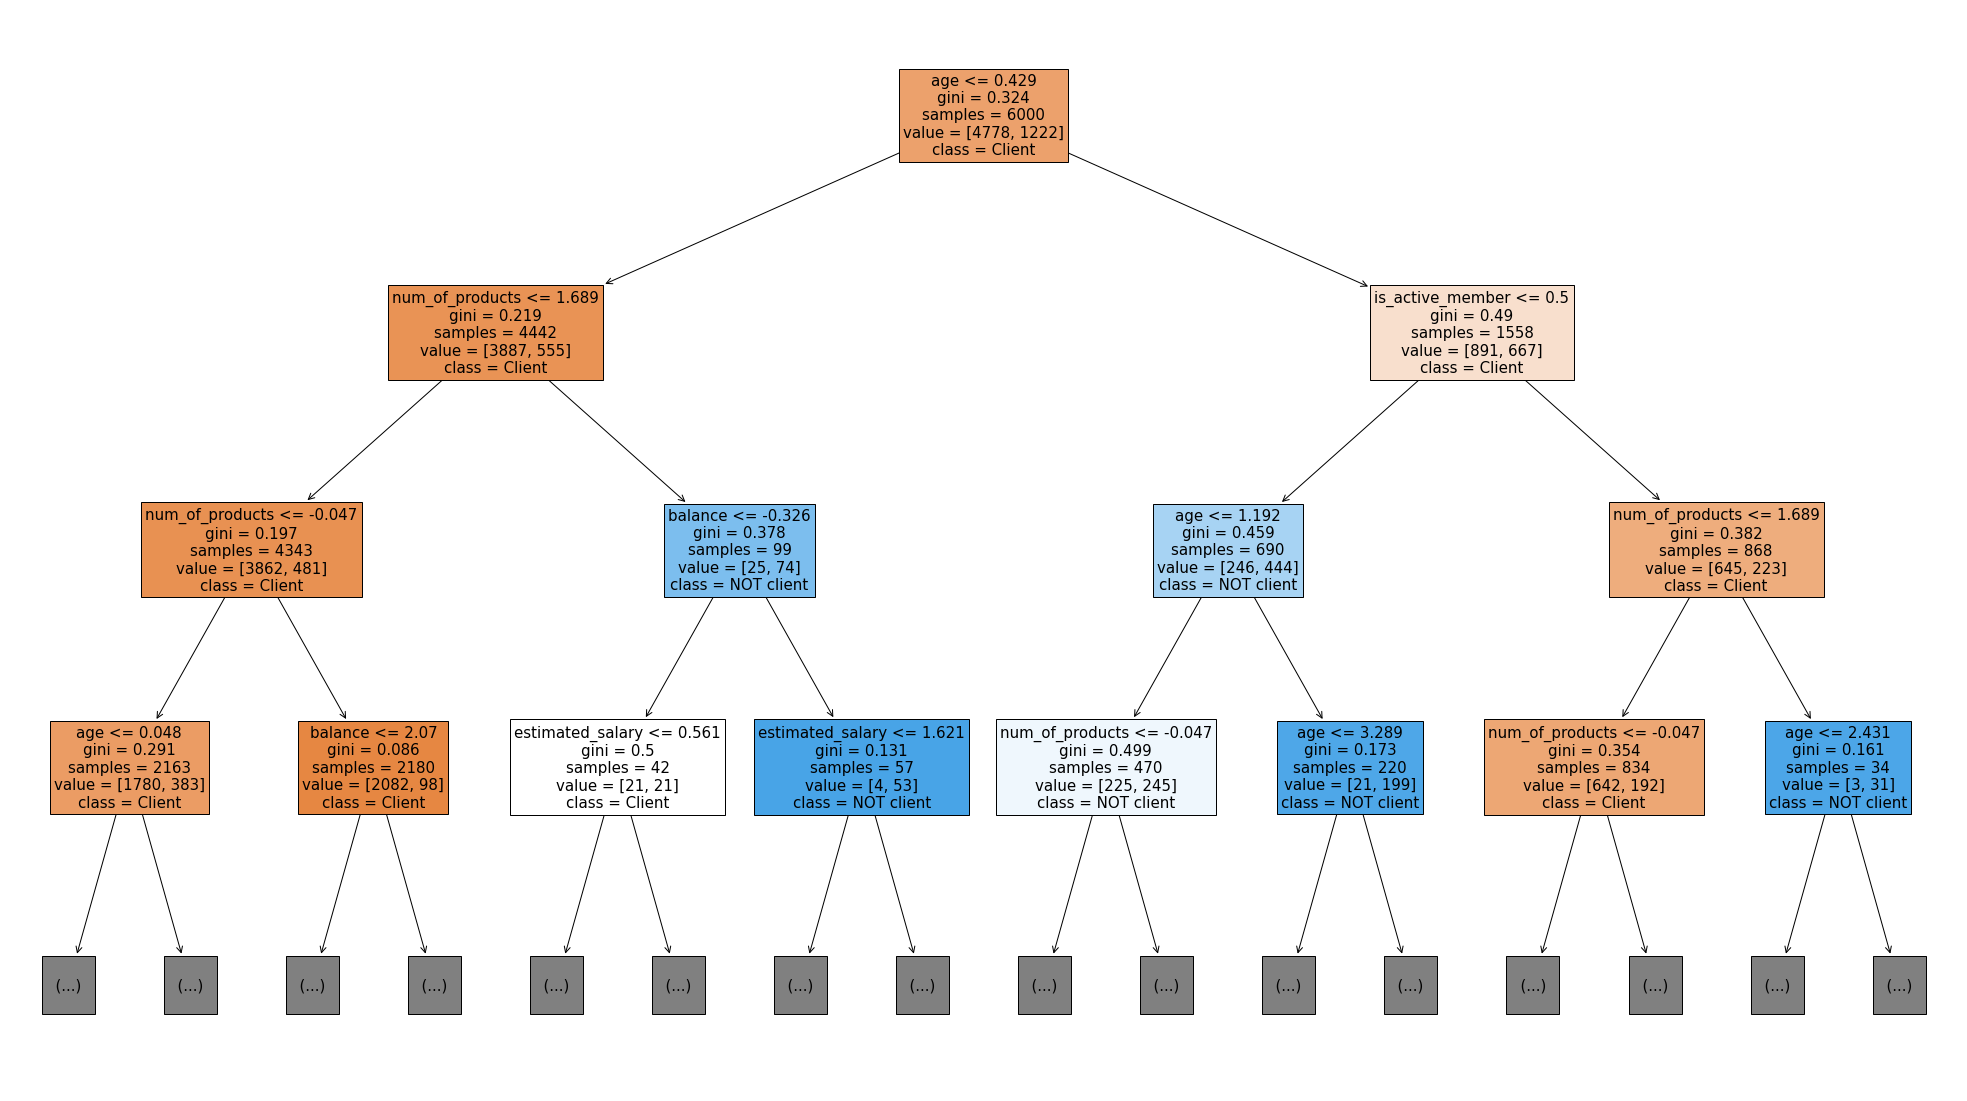

In [ ]:
fig = plt.figure(figsize=(35,20))
tree.plot_tree(best_DT_1, 
                   feature_names=features_train.columns.values, 
                   class_names=['Client','NOT client'],
                   filled=True,
                   fontsize = 15,
                   max_depth = 3);

### Модель Случайный лес

In [ ]:
best_f1_2 = 0
best_RF_1 = None
best_depth = 0
best_n_est = 0
best_roc_auc_2 = 0
for n_est in tqdm(range(1, 101, 5)):
    for depth in range(1,20,1):
        model = RandomForestClassifier(n_estimators = n_est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        if f1 > best_f1_2:
            best_f1_2 = f1
            best_depth = depth
            best_n_est = n_est
            best_RF_1 = model
            best_roc_auc_2 = roc_score
print(f'Best DEFAULT Random Forrest: best F1-score {best_f1_2:.4f} | best_n_estimators = {best_n_est} | \
best_depth = {best_depth} | best ROC-AUC = {best_roc_auc_2:.4f}')

100%|██████████| 20/20 [01:54<00:00,  5.74s/it]

Best DEFAULT Random Forrest: best F1-score 0.6233 | best_n_estimators = 61 | best_depth = 15 | best ROC-AUC = 0.8643


In [ ]:
model_list.append(('DEFAULT Random Forrest: ', best_f1_2, best_roc_auc_2))

Лучшей оказалась модель RF с количеством деревьев 46 и глубиной 13. Метрика F1 достигла 0.629

### Модель Логистическая регрессия

In [ ]:
best_iter = 0
best_LR_1 = None
best_f1_3 = 0
best_roc_auc_3 = 0
for i in range (100, 1001, 100):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter = i)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if f1 > best_f1_3:
        best_f1_3 = f1
        best_iter = i
        best_LR_1 = model
        best_roc_auc_3 = roc_score
print(f'Best DEFAULT LR: best F1-score {best_f1_3:.4f} | \
best_iter = {best_iter} | best ROC-AUC = {best_roc_auc_3:.4f}')

Best DEFAULT LR: best F1-score 0.3077 | best_iter = 100 | best ROC-AUC = 0.7875


In [ ]:
model_list.append(('DEFAULT LogisticRegression: ', best_f1_3, best_roc_auc_3))

Лучшей оказалась модель LR с макс кол-вом итераций 100. Метрика f1 при этом оказалсь самой низкой - 0.31

## Борьба с дисбалансом

Посмотрим дисбаланс по целевому признаку:

In [ ]:
target_train.mean()

0.20366666666666666

1 класс - 20%, 0 класс - 80%. Целевой признак не сбалансирован. 

### Меняем веса классов

#### Решающее дерево (class weight)

In [ ]:
best_f1_1 = 0
best_DT_1 = None
best_depth = 0
best_roc_auc_1 = 0
for depth in tqdm(range(1,50,1)):
    #укажем параметр class_weight = 'balanced'
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight = 'balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if f1 > best_f1_1:
        best_f1_1 = f1
        best_depth = depth
        best_DT_1 = model
        best_roc_auc_1 = roc_score
print(f'BALANCED Decision Tree: best F1-score {best_f1_1:.4f} | best_depth = {best_depth} \
 | best ROC-AUC = {best_roc_auc_1:.4f}')

100%|██████████| 49/49 [00:01<00:00, 31.35it/s]

BALANCED Decision Tree: best F1-score 0.5759 | best_depth = 6  | best ROC-AUC = 0.8233


Интересный момент, что значение метрики F1 снизилось до 0.575, по сравнению с деревом, которое обучалось на несбалансированной выборке

In [ ]:
model_list.append(('BALANCED Decision Tree: ', best_f1_1, best_roc_auc_1))

#### Случайный лес (class weight)

In [ ]:
best_f1_2 = 0
best_RF_1 = None
best_depth = 0
best_n_est = 0
best_roc_auc_2 = 0
for n_est in tqdm(range(1, 101, 5)):
    for depth in range(1,20,1):
        #укажем параметр class_weight = 'balanced'
        model = RandomForestClassifier(n_estimators = n_est, max_depth=depth, \
                                       random_state=12345, class_weight = 'balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        if f1 > best_f1_2:
            best_f1_2 = f1
            best_depth = depth
            best_n_est = n_est
            best_RF_1 = model
            best_roc_auc_2 = roc_score
print(f'Best BALANCED Random Forrest: best F1-score {best_f1_2:.4f} | best_n_estimators = {best_n_est} | \
best_depth = {best_depth} | best ROC-AUC = {best_roc_auc_2:.4f}')

100%|██████████| 20/20 [01:45<00:00,  5.25s/it]

Best BALANCED Random Forrest: best F1-score 0.6563 | best_n_estimators = 66 | best_depth = 10 | best ROC-AUC = 0.8701


In [ ]:
model_list.append(('BALANCED Random Forrest: ', best_f1_2, best_roc_auc_2))

Результаты Случайного леса на сбалансированной выборке оказались выше (F1 = 0.653 против 0.629)

#### Логистическая регрессия (class weight)

In [ ]:
best_iter = 0
best_LR_1 = None
best_f1_3 = 0
best_roc_auc_3 = 0
for i in range (100, 1001, 100):
    #укажем параметр class_weight = 'balanced'
    model = LogisticRegression(random_state=12345, solver='liblinear', \
                               max_iter = i, class_weight = 'balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if f1 > best_f1_3:
        best_f1_3 = f1
        best_iter = i
        best_LR_1 = model
        best_roc_auc_3 = roc_score
print(f'Best BALANCED LR: best F1-score {best_f1_3:.4f} | \
best_iter = {best_iter} | best ROC-AUC = {best_roc_auc_3:.4f}')

Best BALANCED LR: best F1-score 0.5290 | best_iter = 100 | best ROC-AUC = 0.7937


Результаты Логистической регрессии на сбалансированной выборке оказались выше (F1 = 0.529 против 0.31). Метрика выросла практически в 2 раза

In [ ]:
model_list.append(('BALANCED LogisticRegression: ', best_f1_3, best_roc_auc_3))

### Upsampling

#### Решающее дерево (upsampling)

Напишем функцию upsampling, которая кратно увеличит количество значений и признаков 1 класса

In [ ]:
def upsampling(features, target, repeat):
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target == 1]
    
    features_upsampled = pd.concat([features_zero] + [features_one] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_one] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled 

Так как у нас дисбаланс 1 к 4, то в функции upsampling возьмем количество повторений 4, чтобы полностью убрать дисбаланс

In [ ]:
repeat = 4
features_train_up, target_train_up = upsampling(features_train, target_train, repeat)

In [ ]:
best_f1_1 = 0
best_DT_1 = None
best_depth = 0
best_roc_auc_1 = 0

for depth in tqdm(range(1,50,1)):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train_up, target_train_up)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if f1 > best_f1_1:
        best_f1_1 = f1
        best_depth = depth
        best_DT_1 = model
        best_roc_auc_1 = roc_score

print(f'UPSAMPLING Decision Tree: best F1-score {best_f1_1:.4f} | best_depth = {best_depth} \
 | best ROC-AUC = {best_roc_auc_1:.4f}')

100%|██████████| 49/49 [00:01<00:00, 25.72it/s]

UPSAMPLING Decision Tree: best F1-score 0.5759 | best_depth = 6  | best ROC-AUC = 0.8233


Метрика F1 ухудшилась по сравнению с рещением задачи на несбалансированной (изначальной) выборке (с 0.59 до 0.58).

In [ ]:
model_list.append(('UPSAMPLING Decision Tree: ', best_f1_1, best_roc_auc_1))

#### Случайный лес (upsampling)

In [ ]:
best_f1_2 = 0
best_RF_1 = None
best_depth = 0
best_n_est = 0
best_roc_auc_2 = 0
for n_est in tqdm(range(1, 101, 5)):
    for depth in range(1,16,1):
        model = RandomForestClassifier(n_estimators = n_est, max_depth=depth, random_state=12345)
        model.fit(features_train_up, target_train_up)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        if f1 > best_f1_2:
            best_f1_2 = f1
            best_depth = depth
            best_n_est = n_est
            best_RF_1 = model
            best_roc_auc_2 = roc_score
print(f'UPSAMPLING Random Forrest: best F1-score {best_f1_2:.4f} | best_n_estimators = {best_n_est} | \
best_depth = {best_depth} | best ROC-AUC = {best_roc_auc_2:.4f}')

100%|██████████| 20/20 [01:43<00:00,  5.17s/it]

UPSAMPLING Random Forrest: best F1-score 0.6495 | best_n_estimators = 36 | best_depth = 10 | best ROC-AUC = 0.8663


Метрика F1 выросла по сравнению с решением задачи на несбалансированной (изначальной) выборке (с 0.62 до 0.65). Площадь под ROC кривой не поменялась

In [ ]:
model_list.append(('UPSAMPLING Random Forrest: ', best_f1_2, best_roc_auc_2))

#### Логистическая регрессия (upsampling)

In [ ]:
best_iter = 0
best_LR_1 = None
best_f1_3 = 0
best_roc_auc_3 = 0
for i in range (100, 1001, 100):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter = i)
    model.fit(features_train_up, target_train_up)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if f1 > best_f1_3:
        best_f1_3 = f1
        best_iter = i
        best_LR_1 = model
        best_roc_auc_3 = roc_score
print(f'UPSAMPLING LR: best F1-score {best_f1_3:.4f} | \
best_iter = {best_iter} | best ROC-AUC = {best_roc_auc_3:.4f}')

UPSAMPLING LR: best F1-score 0.5247 | best_iter = 100 | best ROC-AUC = 0.7938


Метрика F1 выросла значительно по сравнению с рещением задачи на несбалансированной (изначальной) выборке (с 0.31 до 0.52). Площадь под ROC кривой практически не изменилась (0.79)

In [ ]:
model_list.append(('UPSAMPLING LogisticRegression: ', best_f1_3, best_roc_auc_3))

### Downsampling

#### Решающее дерево (downsampling)

Напишем фукнцию downsample

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Дисбаланс 1 к 4, значит для устранения дисбаланса надо взять долю 0.25

In [ ]:
fraction = 0.25
features_train_down, target_train_down = downsample(features_train, target_train, fraction)

In [ ]:
best_f1_1 = 0
best_DT_1 = None
best_depth = 0
best_roc_auc_1 = 0

for depth in tqdm(range(1,50,1)):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train_down, target_train_down)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if f1 > best_f1_1:
        best_f1_1 = f1
        best_depth = depth
        best_DT_1 = model
        best_roc_auc_1 = roc_score

print(f'DOWNSAMPLING Decision Tree: best F1-score {best_f1_1:.4f} | best_depth = {best_depth} \
 | best ROC-AUC = {best_roc_auc_1:.4f}')

100%|██████████| 49/49 [00:00<00:00, 60.69it/s]

DOWNSAMPLING Decision Tree: best F1-score 0.5945 | best_depth = 6  | best ROC-AUC = 0.8478


Метрика F1 по сравнению с методом upsampling улучшилась (с 0.58 до 0.59)

In [ ]:
model_list.append(('DOWNSAMPLING Decision Tree: ', best_f1_1, best_roc_auc_1))

#### Случайный лес (downsampling)

In [ ]:
best_f1_2 = 0
best_RF_1 = None
best_depth = 0
best_n_est = 0
best_roc_auc_2 = 0
for n_est in tqdm(range(1, 101, 5)):
    for depth in range(1,20,1):
        model = RandomForestClassifier(n_estimators = n_est, max_depth=depth, random_state=12345)
        model.fit(features_train_down, target_train_down)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        if f1 > best_f1_2:
            best_f1_2 = f1
            best_depth = depth
            best_n_est = n_est
            best_RF_1 = model
            best_roc_auc_2 = roc_score
print(f'DOWNSAMPLING Random Forrest: best F1-score {best_f1_2:.4f} | best_n_estimators = {best_n_est} | \
best_depth = {best_depth} | best ROC-AUC = {best_roc_auc_2:.4f}')

100%|██████████| 20/20 [01:03<00:00,  3.16s/it]

DOWNSAMPLING Random Forrest: best F1-score 0.6395 | best_n_estimators = 26 | best_depth = 7 | best ROC-AUC = 0.8655


Метрика F1 немного ухудшилась по сравнению с методом upsampling (0.65 до 0.64)

In [ ]:
model_list.append(('DOWNSAMPLING Random Forrest: ', best_f1_2, best_roc_auc_2))

#### Логистическая регрессия (downsampling)

In [ ]:
best_iter = 0
best_LR_1 = None
best_f1_3 = 0
best_roc_auc_3 = 0
for i in range (100, 1001, 100):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter = i)
    model.fit(features_train_down, target_train_down)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    roc_score = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if f1 > best_f1_3:
        best_f1_3 = f1
        best_iter = i
        best_LR_1 = model
        best_roc_auc_3 = roc_score
print(f'DOWNSAMPLING LR: best F1-score {best_f1_3:.4f} | \
best_iter = {best_iter} | best ROC-AUC = {best_roc_auc_3:.4f}')

DOWNSAMPLING LR: best F1-score 0.5276 | best_iter = 100 | best ROC-AUC = 0.7926


Метрика F1 практически не изменилась по сравнению с методом upsampling (0.52)

In [ ]:
model_list.append(('DOWNSAMPLING LogisticRegression: ', best_f1_3, best_roc_auc_3))

## Тестирование модели

Посмотрим на полученные метрики моделей и определим лучшую

In [ ]:
ml = pd.DataFrame(model_list)
ml.columns = ('Name', 'F1-score', 'AUC-ROC')
ml = ml.sort_values(by='F1-score', ascending=False)
ml

,Name,F1-score,AUC-ROC
4,BALANCED Random Forrest:,0.656287,0.870118
7,UPSAMPLING Random Forrest:,0.649462,0.866251
10,DOWNSAMPLING Random Forrest:,0.639535,0.865464
1,DEFAULT Random Forrest:,0.623338,0.864327
9,DOWNSAMPLING Decision Tree:,0.594492,0.847777
0,DEFAULT DT:,0.592486,0.823039
3,BALANCED Decision Tree:,0.575926,0.823327
6,UPSAMPLING Decision Tree:,0.575926,0.823342
5,BALANCED LogisticRegression:,0.528998,0.793700
11,DOWNSAMPLING LogisticRegression:,0.527586,0.792603


Лучшей метрикой на валидационной выборке обладает Случайный лес (глубина дерева 10, количество деревьев 66) при использовании метода балансировки весов (class weight = 'balabced') для устранения дисбаланса

### Дообучение финальной модели

Дообучим выбранную финальную модель на обучающей и валидационной выборках. Для этого объединим их, проведем upsampling и перемешивание

In [ ]:
print(features_train.shape[0])
print(features_valid.shape[0])

6000
2000


In [ ]:
features_train_valid = pd.concat([features_train] + [features_valid])
features_train_valid.shape[0]

8000

In [ ]:
target_train_valid = pd.concat([target_train] + [target_valid])
target_train_valid.shape[0]

8000

Объединение прошло успешно. Теперь обучим модель Случайный лес на объединенных данных

In [ ]:
final_model = RandomForestClassifier(n_estimators = 66,
                               max_depth=10, 
                               random_state=12345,
                               class_weight = 'balanced')
final_model.fit(features_train_valid, target_train_valid)
predicted_test = final_model.predict(features_test)
f1 = f1_score(target_test, predicted_test)
roc_score = roc_auc_score(target_test, final_model.predict_proba(features_test)[:, 1])

print(f'BALANCED Random Forrest: best F1-score {f1:.4f} | best ROC-AUC = {roc_score:.4f}')

BALANCED Random Forrest: best F1-score 0.6079 | best ROC-AUC = 0.8556


На тестовой выборке лучшая модель показала результат F1 = 0.608, что выше требуемых в задании 0.59

### Построение ROC кривой

Построим ROC кривую для финальной модели

In [ ]:
probabilities_test = final_model.predict_proba(features_test)
y = pd.DataFrame(probabilities_test)
y

,0,1
0,0.571424,0.428576
1,0.777897,0.222103
2,0.288682,0.711318
3,0.765437,0.234563
4,0.076015,0.923985
...,...,...
1995,0.077604,0.922396
1996,0.926462,0.073538
1997,0.739009,0.260991
1998,0.927198,0.072802


In [ ]:
y_score = probabilities_test[:, 1]
y['y_score'] = y_score
y

,0,1,y_score
0,0.571424,0.428576,0.428576
1,0.777897,0.222103,0.222103
2,0.288682,0.711318,0.711318
3,0.765437,0.234563,0.234563
4,0.076015,0.923985,0.923985
...,...,...,...
1995,0.077604,0.922396,0.922396
1996,0.926462,0.073538,0.073538
1997,0.739009,0.260991,0.260991
1998,0.927198,0.072802,0.072802


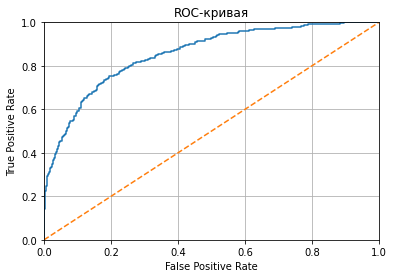

In [ ]:
fpr, tpr, thrs = roc_curve(target_test, y_score) 
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show();

In [ ]:
auc(fpr, tpr)

0.8555597199664996

Финальная модель обладает следующими характеристиками:
 - F1 = 0.608
 - AUC-ROC = 0.857, что говорит о высоком качестве модели (0.853 много больше 0.5 (случайная модель)

### Сравнение лучшей модели со случайной

Добавим сравнение по f1-мере с константной моделью, которая постоянно предсказывает 1.
Также посмотрим recall (полноту) и прокомментируем, какую долю клиентов на отток модель верно детектирует.


Используем дамми-модель с константым предсказанием везде «1» (решили раздать бонусы вообще всем клиентам). Если в дамми-модели предсказываем по единице, можно подсчитать F1, она не будет зануляться.

In [ ]:
model_1 = DummyClassifier(strategy="constant", constant=1)
model_1.fit(features_train_valid, target_train_valid)
predicted_1 = model_1.predict(features_test)
#predicted_1

In [ ]:
print(f'F1 score for constant 1 model = {f1_score(target_test, predicted_1)}')
print(f'F1 score for best final model = {f1_score(target_test, final_model.predict(features_test))}')

F1 score for constant 1 model = 0.3381803074366431
F1 score for best final model = 0.6078665077473183


Видим, что метрика F1 для нашей лучшей модели в 2 раза выше, чем для случайной константной модели (всем 1). Значит мы поработали не зря)) 

Посмотрим метрику Recall. Перед этим построим матрицу ошибок

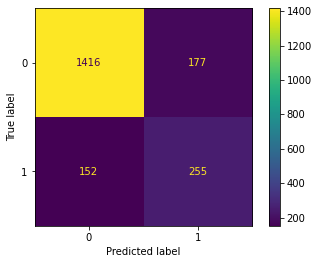

In [ ]:
cm = confusion_matrix(target_test, final_model.predict(features_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = final_model.classes_)

disp.plot();

In [ ]:
recall_final_model = recall_score(target_test, final_model.predict(features_test))

print(f'Recall score for final model = {recall_final_model}')

Recall score for final model = 0.6265356265356266


62.7% клиента от первоначальных (тех, кто ушел) модель классифицировала верно

Посмотрим на точность модели:

In [ ]:
print(f'Precision for final model = {precision_score(target_test, final_model.predict(features_test))}')

Precision for final model = 0.5902777777777778


Точность определения (уйдет или не уйдет клиент) составила 59%

### Выводы

В процессе работы было сделано:
- предобработка данных: удалены лишние признаки и заполнены пропуски в столбце tenure медианным значением;
- данные были разделены на 3 выборки: обучающую, валидационную и тестовую выборки с сохранением стратификации целевого признака;
- категориальные признаки преобразовали в численные методом ОНЕ;
- масштабирование численных признаков методом стандартизации;
- обучены модели линейной регрессии, дерева решений и случайного леса с учетом дисбаланса классов и без учета дисбаланса;
- выявлено, что при учете дисбаланса метрики моделей улучшаются. Лучшие результаты по метрике F1 score показала модель Случайный лес (даже без устранения дисбаланса эта модель показывала самые высокие относительно других моделей (дерева решений и логистической регрессии) результаты

Было получено:
- в качестве финальной модели для проверки на тестовой выборке была выбрана модель Случайный лес (глубина 10, количество деревьев 36). Её обучение провелось на обучающей и валидационных выборках
- Метрики финальной модели на тестовой выборке:
  - F1 score = 0.608 (выше требуемых в задании 0.59)
  - AUC-ROC = 0.853 что говорит о высоком качестве модели (0.853 много больше 0.5 (случайная модель)
  - Recall = 62.7% (клиентов от первоначальных (тех, кто ушел) модель классифицировала верно)
  - Precision = 59%